# Configure Preprocessing Params

This notebook should be used to set up preprocessing params.
Cells marked with <font color='red'>SET PARAMETERS</font> contain crucial variables that need to be set according to your specific experimental setup and data organization.
Please review and modify these variables as needed before proceeding with the analysis.

## Imports

In [1]:
from pathlib import Path

import yaml
from microfilm.microplot import Microimage
import matplotlib.pyplot as plt
import pandas as pd

from lib.shared.configuration_utils import (
    CONFIG_FILE_HEADER,
    create_samples_df,
    create_micropanel,
)
from lib.preprocess.preprocess import extract_well_metadata, nd2_to_tiff_well
from lib.preprocess.file_utils import get_sample_fps

## <font color='red'>SET PARAMETERS</font>

### Fixed parameters for preprocessing

- `CONFIG_FILE_PATH`: Path to a Brieflow config file used during processing*.
- `ROOT_FP`: Path to root of Brieflow output directory*.

*Note: Paths can be absolute or relative to where workflows are run from.

In [2]:
CONFIG_FILE_PATH = "config/config.yml"
ROOT_FP = "analysis_root/"

Path(CONFIG_FILE_PATH).parent.mkdir(parents=True, exist_ok=True)
Path(ROOT_FP).mkdir(parents=True, exist_ok=True)

## <font color='red'>SET PARAMETERS</font>

### Paths to dataframes with sample information

- `SBS_SAMPLES_DF_FP`/`PHENOTYPE_SAMPLES_DF_FP`: Path to dataframe where SBS/phenotype samples location and metadata will be stored.
- `SBS_COMBO_DF_FP`/`PHENOTYPE_COMBO_DF_FP`: Path to dataframe where SBS/phenotype sample metadata combinations will be stored.
- `SBS_IMAGES_DIR_FP`/`PHENOTYPE_IMAGES_DIR_FP`: Path to directories with SBS/phenotype sample nd2 files. Set to `None` to ignore SBS/phenotype testing in this notebook.

### Pattern configurations for metadata extraction

#### SBS Configuration
- `SBS_PATH_PATTERN`: Regex pattern to match directory structure of SBS files
- `SBS_PATH_METADATA`: List of metadata to extract from file path
    - Should include at least `"plate", "well", "tile, "cycle""` to extract SBS processing information
- `SBS_METADATA_ORDER_TYPE`: Metadata order will be used to organize the file paths dataframe. Metadata types will be used to convert parsed information.

#### Phenotype Configuration
- `PHENOTYPE_PATH_PATTERN`: Regex pattern to match directory structure of phenotype files  
- `PHENOTYPE_PATH_METADATA`: List of metadata to extract from file path
    - Should include at least `"plate", "well", "tile"` to extract phentoype processing information
- `PHENOTYPE_METADATA_ORDER_TYPE`: Metadata order will be used to organize the file paths dataframe. Metadata types will be used to convert parsed information.

*Notes:*
- Paths can be absolute or relative to where workflows are run from
- Each pattern (path and sample) should have the same number of capture groups as pieces of metadata listed
- Metadata lists should be ordered to match the capture groups in their corresponding regex pattern
- For both path and sample patterns, numeric values (like cycle numbers) will automatically be converted to integers
- For Brieflow to run effectively, each sample fil epath should have an associated plate/well. For single plate/well screens manually add a plate/well to the file path dataframe.

In [3]:
# paths to sample dataframes
SBS_SAMPLES_DF_FP = "config/sbs_samples.tsv"
PHENOTYPE_SAMPLES_DF_FP = "config/phenotype_samples.tsv"

# Directory, pattern, and metadata for SBS sample nd2 files
SBS_IMAGES_DIR_FP = Path("/lab/barcheese01/brieflow_screens/aconcagua/data/input_sbs")
SBS_SAMPLE_PATTERN = r"plate_(\d+)/c(\d+)/\d+_\d+_\d+/Well([A-Z]\d+)_Channel([A-Za-z0-9_-]+)_Seq\d+\.nd2"
SBS_PATH_METADATA = ["plate", "cycle", "well", "channel"]
SBS_METADATA_ORDER_TYPE = {
    "plate": int,
    "well": str,
    "cycle": int,
    "channel": str
}

# Constants for phenotype channels
PHENOTYPE_CHANNEL_ORDER = ["DAPI_1x1-GFP_1x1", "GFP_1x1", "A594_1x1", "AF750_1x1"]

# Directory, pattern, and metadata for phenotype sample nd2 files
PHENOTYPE_IMAGES_DIR_FP = Path("/lab/barcheese01/brieflow_screens/aconcagua/data/input_ph")
PHENOTYPE_SAMPLE_PATTERN = r"plate_(\d+)/round_(\d+)/\d+_\d+_\d+/Well([A-Z]\d+)_Channel((?:DAPI_1x1-GFP_1x1|GFP_1x1|A594_1x1|AF750_1x1))_Seq\d+\.nd2"
PHENOTYPE_PATH_METADATA = ["plate", "round", "well", "channel"]
PHENOTYPE_METADATA_ORDER_TYPE = {
    "plate": int,
    "well": str,
    "round": int,
    "channel": str
}

You must supply a working regex to the _PATTERN variables. If you don't have experience with regex, you can use the following LLM prompt to generate the example sample patterns.

_Enter into a basic LLM chatbot_: Given ND2 filenames from your experiment, generate regex patterns to extract metadata. Return only the regex patterns with no explanation.

Example filenames:
[ENTER YOUR EXAMPLE FILES HERE]

Required regex patterns (return these exact variable assignments):

```python
SBS_PATH_PATTERN = r"..."      # To match file path structure
PHENOTYPE_PATH_PATTERN = r"..." # To match file path structure
```

The patterns should extract:

1. SBS pattern:
     - Plate number (after "plate_")
     - Cycle number (after "/c")
     - Well ID (e.g., "A1", "B2")
     - Tile number (after "Points-")

2. PHENOTYPE pattern:
     - Plate number (after "plate_")
     - Well ID (e.g., "A1", "B2")
     - Tile number (after "Points-")

The patterns will be used like this:
```python
# Path pattern matching
path_match = re.search(PATH_PATTERN, filepath)
plate = path_match.group(1)
cycle = int(path_match.group(2))  # For SBS only

# Sample pattern matching
sample_match = re.search(SAMPLE_PATTERN, filename)
plate = sample_match.group(1)
well = sample_match.group(2)
```

Example patterns for reference:
```python
SBS_PATH_PATTERN = r"plate_(\d+)/c(\d+)/.*_Wells-([A-Z]\d+)_Points-(\d+)__.*"
PHENOTYPE_PATH_PATTERN = r"P(\d+)_Pheno_20x_Wells-([A-Z]\d+)_Points-(\d+)__.*"
```

## Create Sample DFs

In [4]:
sbs_samples = create_samples_df(
    SBS_IMAGES_DIR_FP, SBS_SAMPLE_PATTERN, SBS_PATH_METADATA, SBS_METADATA_ORDER_TYPE
)
# Save and display sample dataframe
sbs_samples.to_csv(SBS_SAMPLES_DF_FP, sep="\t", index=False)
print("SBS samples:")
display(sbs_samples)

# Create sample dataframe for phenotype
phenotype_samples = create_samples_df(
    PHENOTYPE_IMAGES_DIR_FP,
    PHENOTYPE_SAMPLE_PATTERN,
    PHENOTYPE_PATH_METADATA,
    PHENOTYPE_METADATA_ORDER_TYPE,
)
# Save and display sample dataframe
phenotype_samples.to_csv(PHENOTYPE_SAMPLES_DF_FP, sep="\t", index=False)
print("Phenotype samples:")
display(phenotype_samples)

SBS samples:


sample_fp  plate well  cycle  \
0     /lab/barcheese01/brieflow_screens/aconcagua/da...      1   A1      1   
1     /lab/barcheese01/brieflow_screens/aconcagua/da...      1   A1      2   
2     /lab/barcheese01/brieflow_screens/aconcagua/da...      1   A1      2   
3     /lab/barcheese01/brieflow_screens/aconcagua/da...      1   A1      2   
4     /lab/barcheese01/brieflow_screens/aconcagua/da...      1   A1      2   
...                                                 ...    ...  ...    ...   
1840  /lab/barcheese01/brieflow_screens/aconcagua/da...      8   B3     10   
1841  /lab/barcheese01/brieflow_screens/aconcagua/da...      8   B3     11   
1842  /lab/barcheese01/brieflow_screens/aconcagua/da...      8   B3     11   
1843  /lab/barcheese01/brieflow_screens/aconcagua/da...      8   B3     11   
1844  /lab/barcheese01/brieflow_screens/aconcagua/da...      8   B3     11   

                                        channel  
0     DAPI-CY3_30p_545-A594_30p-CY5_30p-CY7_30p  
1                                      A594_30p  
2                                   CY3_30p_545  
3                                       CY5_30p  
4                                       CY7_30p  
...                                         ...  
1840                                    CY7_30p  
1841                                   A594_30p  
1842                                CY3_30p_545  
1843                                    CY5_30p  
1844                                    CY7_30p  

[1845 rows x 5 columns]

Phenotype samples:


sample_fp  plate well  round  \
0    /lab/barcheese01/brieflow_screens/aconcagua/da...      1   A1      1   
1    /lab/barcheese01/brieflow_screens/aconcagua/da...      1   A1      1   
2    /lab/barcheese01/brieflow_screens/aconcagua/da...      1   A1      1   
3    /lab/barcheese01/brieflow_screens/aconcagua/da...      1   A2      1   
4    /lab/barcheese01/brieflow_screens/aconcagua/da...      1   A2      1   
..                                                 ...    ...  ...    ...   
158  /lab/barcheese01/brieflow_screens/aconcagua/da...      8   B2      2   
159  /lab/barcheese01/brieflow_screens/aconcagua/da...      8   B3      1   
160  /lab/barcheese01/brieflow_screens/aconcagua/da...      8   B3      1   
161  /lab/barcheese01/brieflow_screens/aconcagua/da...      8   B3      1   
162  /lab/barcheese01/brieflow_screens/aconcagua/da...      8   B3      2   

              channel  
0            A594_1x1  
1           AF750_1x1  
2    DAPI_1x1-GFP_1x1  
3            A594_1x1  
4           AF750_1x1  
..                ...  
158           GFP_1x1  
159          A594_1x1  
160         AF750_1x1  
161  DAPI_1x1-GFP_1x1  
162           GFP_1x1  

[163 rows x 5 columns]

## Test Metadata Extraction

In [5]:
if SBS_IMAGES_DIR_FP is not None:
    # Extract metadata from test sbs sample
    test_sbs_metadata = extract_well_metadata(
        sbs_samples["sample_fp"][0],
        sbs_samples["plate"][0],
        sbs_samples["well"][0],
        sbs_samples["cycle"][0],
        verbose=True,
    )
    print("SBS test metadata:")
    display(test_sbs_metadata)

if PHENOTYPE_IMAGES_DIR_FP is not None:
    # Extract metadata from test phenotype sample
    test_phenotype_metadata = extract_well_metadata(
        phenotype_samples["sample_fp"][0],
        phenotype_samples["plate"][0],
        phenotype_samples["well"][0],
        verbose=True,
    )
    print("Phenotype test metadata:")
    display(test_phenotype_metadata)

Processing well file: /lab/barcheese01/brieflow_screens/aconcagua/data/input_sbs/plate_1/c1/20200218_141421_172/WellA1_ChannelDAPI-CY3_30p_545-A594_30p-CY5_30p-CY7_30p_Seq0000.nd2
File shape: (333, 5, 1480, 1480)
Number of dimensions: 4
Data type: uint16
Sizes (by axes): {'P': 333, 'C': 5, 'Y': 1480, 'X': 1480}
Number of positions: 333
Number of Z planes: 1
SBS test metadata:


x_pos    y_pos    z_pos pfs_offset  plate well  tile  cycle  \
0    41807.6 -36042.4  6866.11       None      1   A1     0      1   
1    40280.3 -36028.3  6866.11       None      1   A1     1      1   
2    38752.7 -36014.6  6866.11       None      1   A1     2      1   
3    37225.1 -36000.8  6866.11       None      1   A1     3      1   
4    35697.8 -35986.8  6866.11       None      1   A1     4      1   
..       ...      ...      ...        ...    ...  ...   ...    ...   
328  42084.9  -5492.3  6874.48       None      1   A1   328      1   
329  40557.5  -5478.3  6874.84       None      1   A1   329      1   
330  39030.0  -5464.5  6875.66       None      1   A1   330      1   
331  37502.4  -5450.7  6875.77       None      1   A1   331      1   
332  35975.0  -5436.7  6876.10       None      1   A1   332      1   

                                              filename  channels  \
0    /lab/barcheese01/brieflow_screens/aconcagua/da...         5   
1    /lab/barcheese01/brieflow_screens/aconcagua/da...         5   
2    /lab/barcheese01/brieflow_screens/aconcagua/da...         5   
3    /lab/barcheese01/brieflow_screens/aconcagua/da...         5   
4    /lab/barcheese01/brieflow_screens/aconcagua/da...         5   
..                                                 ...       ...   
328  /lab/barcheese01/brieflow_screens/aconcagua/da...         5   
329  /lab/barcheese01/brieflow_screens/aconcagua/da...         5   
330  /lab/barcheese01/brieflow_screens/aconcagua/da...         5   
331  /lab/barcheese01/brieflow_screens/aconcagua/da...         5   
332  /lab/barcheese01/brieflow_screens/aconcagua/da...         5   

     pixel_size_x  pixel_size_y  
0        1.214286      1.214286  
1        1.214286      1.214286  
2        1.214286      1.214286  
3        1.214286      1.214286  
4        1.214286      1.214286  
..            ...           ...  
328      1.214286      1.214286  
329      1.214286      1.214286  
330      1.214286      1.214286  
331      1.214286      1.214286  
332      1.214286      1.214286  

[333 rows x 12 columns]

Processing well file: /lab/barcheese01/brieflow_screens/aconcagua/data/input_ph/plate_1/round_1/20200205_173225_166/WellA1_ChannelA594_1x1_Seq0001.nd2
File shape: (1281, 4, 2960, 2960)
Number of dimensions: 4
Data type: uint16
Sizes (by axes): {'P': 1281, 'Z': 4, 'Y': 2960, 'X': 2960}
Number of positions: 1281
Number of Z planes: 4
Phenotype test metadata:


x_pos    y_pos    z_pos pfs_offset  plate well  tile cycle  \
0     41062.7 -36016.9  3963.27       None      1   A1     0  None   
1     40299.1 -36010.1  3963.27       None      1   A1     1  None   
2     39535.1 -36003.2  3963.69       None      1   A1     2  None   
3     38771.4 -35996.1  3963.69       None      1   A1     3  None   
4     38007.6 -35989.2  3963.69       None      1   A1     4  None   
...       ...      ...      ...        ...    ...  ...   ...   ...   
1276  39812.3  -5452.9  3977.29       None      1   A1  1276  None   
1277  39048.8  -5446.2  3977.29       None      1   A1  1277  None   
1278  38284.8  -5439.0  3977.29       None      1   A1  1278  None   
1279  37521.2  -5432.3  3977.88       None      1   A1  1279  None   
1280  36757.5  -5425.3  3977.71       None      1   A1  1280  None   

                                               filename  channels  \
0     /lab/barcheese01/brieflow_screens/aconcagua/da...         1   
1     /lab/barcheese01/brieflow_screens/aconcagua/da...         1   
2     /lab/barcheese01/brieflow_screens/aconcagua/da...         1   
3     /lab/barcheese01/brieflow_screens/aconcagua/da...         1   
4     /lab/barcheese01/brieflow_screens/aconcagua/da...         1   
...                                                 ...       ...   
1276  /lab/barcheese01/brieflow_screens/aconcagua/da...         1   
1277  /lab/barcheese01/brieflow_screens/aconcagua/da...         1   
1278  /lab/barcheese01/brieflow_screens/aconcagua/da...         1   
1279  /lab/barcheese01/brieflow_screens/aconcagua/da...         1   
1280  /lab/barcheese01/brieflow_screens/aconcagua/da...         1   

      pixel_size_x  pixel_size_y  
0         0.303571      0.303571  
1         0.303571      0.303571  
2         0.303571      0.303571  
3         0.303571      0.303571  
4         0.303571      0.303571  
...            ...           ...  
1276      0.303571      0.303571  
1277      0.303571      0.303571  
1278      0.303571      0.303571  
1279      0.303571      0.303571  
1280      0.303571      0.303571  

[1281 rows x 12 columns]

## <font color='red'>SET PARAMETERS</font>

### ND2 conversion

- `SBS_CHANNEL_ORDER`/`PHENOTYPE_CHANNEL_ORDER`: Manually set channel order _if ND2 images are acquired as single channels, or there are multiple files for each tile (e.g. multiple rounds of phenotype images). Should be `None` if multichannel image files are acquired. The extracted channel names must match the values that will be displayed in the samples DataFrame channel column (e.g., `["DAPI", "GFP", "CY3", "CY5", "AF750"]`).
- `PHENOTYPE_ROUND_ORDER`: List of round numbers specifying the order in which to process phenotype image rounds. Should be `None` if there is only one round of phenotyping. For multiple rounds, specify the round numbers in the desired order (e.g., `[1, 2, 3]`). The round numbers must match the values in the samples DataFrame round column.

**Note** For single-channel files, each file must contain a channel identifier that your regex can extract. For multichannel files, set the channel patterns to `None`. Metadata extraction is only performed on the first channel dimension for each tile. Please ensure the Dapi channel is displayed first!

- `SBS_CHANNEL_ORDER_FLIP`/`PHENOTYPE_CHANNEL_ORDER_FLIP`: Whether or not to flip channel order when converting ND2->tiff. Should be `False` if channels are in a standard order (with Dapi first), or `True` if channels are reversed. This will only occur for multichannel ND2 files, for each individual ND2 file. Setting the channel order for single channel files is done by setting `SBS_CHANNEL_ORDER`/`PHENOTYPE_CHANNEL_ORDER` previously.

**Note** Channel order can be checked with the test conversions below. Please ensure the Dapi channel is displayed first!

In [6]:
SBS_CHANNEL_ORDER = ["CY3_30p_545", "A594_30p", "CY5_30p", "CY7_30p"]
PHENOTYPE_CHANNEL_ORDER = ["DAPI_1x1-GFP_1x1", "GFP_1x1", "A594_1x1", "AF750_1x1"]
PHENOTYPE_ROUND_ORDER = [1, 2]

In [7]:
SBS_CHANNEL_ORDER_FLIP = None
PHENOTYPE_CHANNEL_ORDER_FLIP = None

## Test ND2 Conversion

### Test SBS conversion

##### Multichannel (first cycle)


Processing file: /lab/barcheese01/brieflow_screens/aconcagua/data/input_sbs/plate_1/c1/20200218_141421_172/WellA1_ChannelDAPI-CY3_30p_545-A594_30p-CY5_30p-CY7_30p_Seq0000.nd2
File dimensions: {'P': 333, 'C': 5, 'Y': 1480, 'X': 1480}
Frame shape after Z processing: (5, 1480, 1480)
Final dimensions (CYX): (5, 1480, 1480)
Array size in bytes: 21904000
Converted SBS test sample:


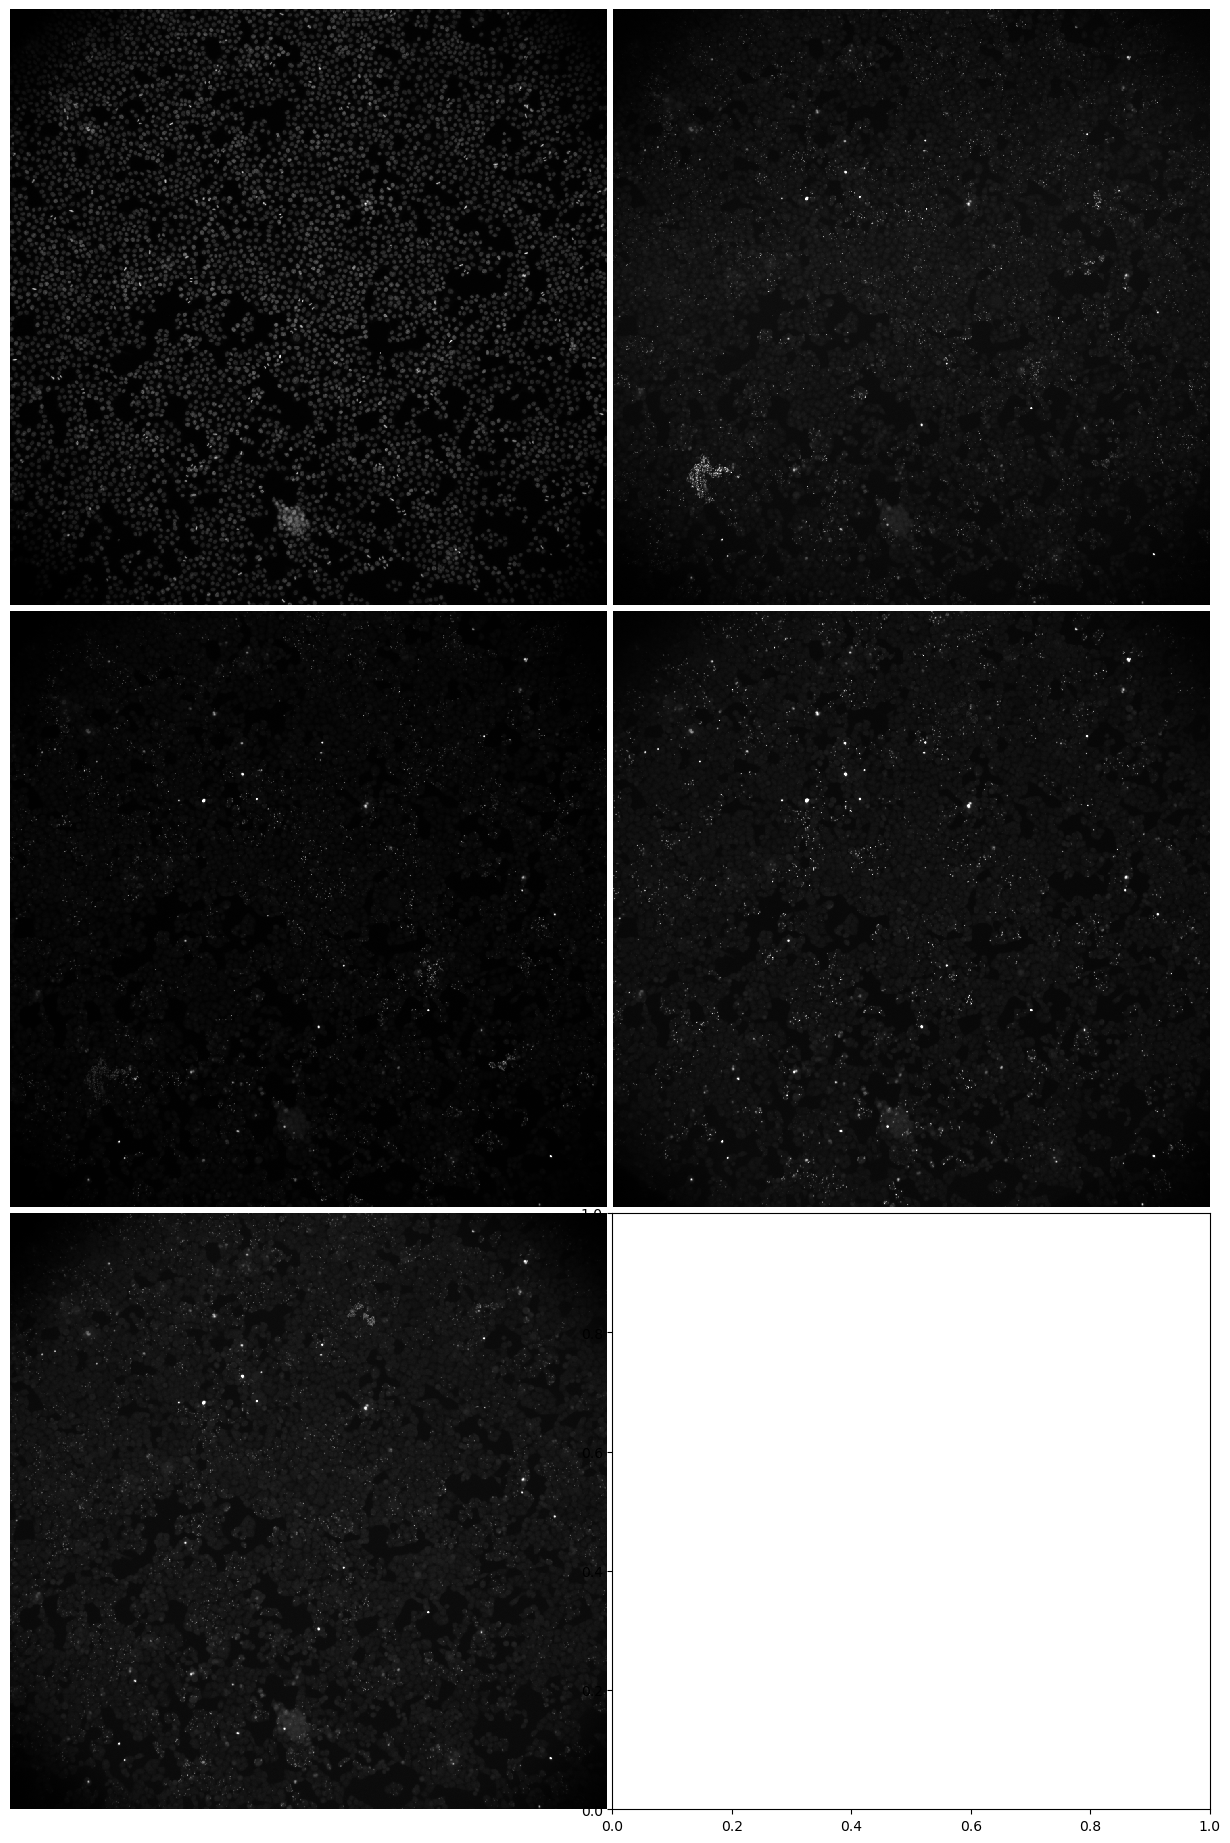

In [8]:
if SBS_IMAGES_DIR_FP is not None:
    # Get test sbs sample
    sbs_sample = get_sample_fps(
        sbs_samples,
        plate=sbs_samples["plate"][0],
        well=sbs_samples["well"][0],
        cycle=1,
        channel_order=None,
    )

    # Convert test sbs sample to tiff
    sbs_image, SBS_TILES = nd2_to_tiff_well(sbs_sample, position=0, channel_order_flip=SBS_CHANNEL_ORDER_FLIP, return_tiles=True, verbose=True)    
    # Create micropanel to display converted samples
    print("Converted SBS test sample:")
    sbs_microimages = [Microimage(image) for image in sbs_image]
    sbs_panel = create_micropanel(sbs_microimages, add_channel_label=False)
    plt.show()

##### Single channel (last cycle)


Processing file: /lab/barcheese01/brieflow_screens/aconcagua/data/input_sbs/plate_1/c2/20200224_101922_191/WellA1_ChannelCY3_30p_545_Seq0000.nd2
File dimensions: {'P': 333, 'Y': 1480, 'X': 1480}
Frame shape after Z processing: (1480, 1480)

Processing file: /lab/barcheese01/brieflow_screens/aconcagua/data/input_sbs/plate_1/c2/20200224_101922_191/WellA1_ChannelA594_30p_Seq0006.nd2
File dimensions: {'P': 333, 'Y': 1480, 'X': 1480}
Frame shape after Z processing: (1480, 1480)

Processing file: /lab/barcheese01/brieflow_screens/aconcagua/data/input_sbs/plate_1/c2/20200224_101922_191/WellA1_ChannelCY5_30p_Seq0012.nd2
File dimensions: {'P': 333, 'Y': 1480, 'X': 1480}
Frame shape after Z processing: (1480, 1480)

Processing file: /lab/barcheese01/brieflow_screens/aconcagua/data/input_sbs/plate_1/c2/20200224_101922_191/WellA1_ChannelCY7_30p_Seq0018.nd2
File dimensions: {'P': 333, 'Y': 1480, 'X': 1480}
Frame shape after Z processing: (1480, 1480)
Final dimensions (CYX): (4, 1480, 1480)
Array s

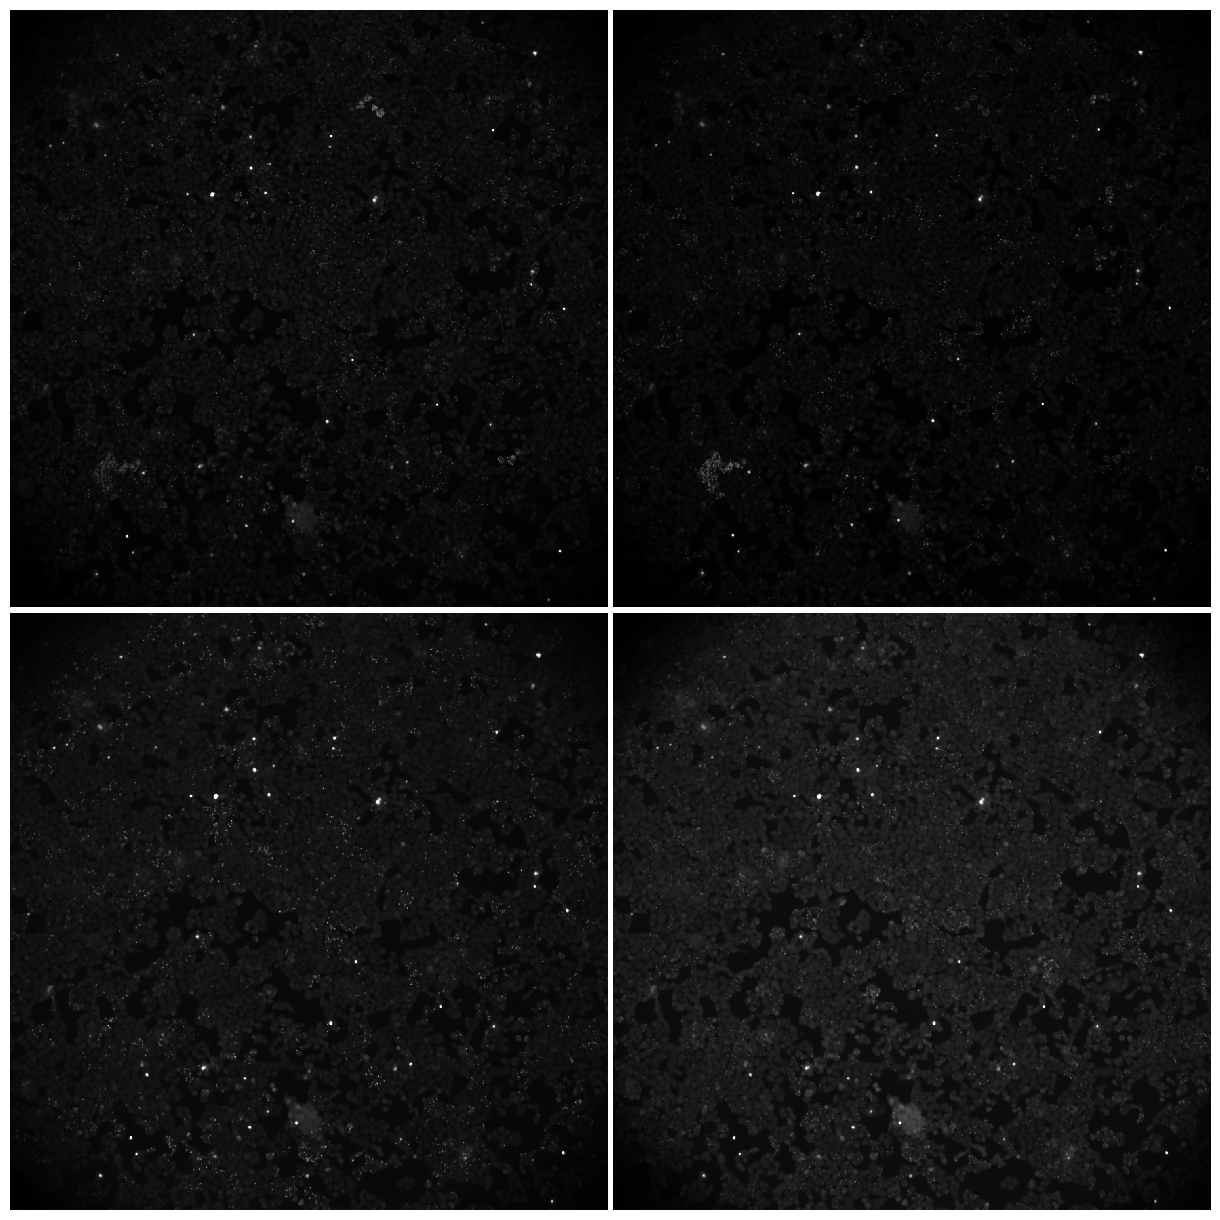

In [9]:
if SBS_IMAGES_DIR_FP is not None:
    # Get test sbs sample
    sbs_sample = get_sample_fps(
        sbs_samples,
        plate=sbs_samples["plate"][0],
        well=sbs_samples["well"][0],
        cycle=2,
        channel_order=SBS_CHANNEL_ORDER,
    )

    # Convert test sbs sample to tiff
    sbs_image, SBS_TILES = nd2_to_tiff_well(sbs_sample, position=0, channel_order_flip=SBS_CHANNEL_ORDER_FLIP, return_tiles=True, verbose=True)    
    # Create micropanel to display converted samples
    print("Converted SBS test sample:")
    sbs_microimages = [Microimage(image) for image in sbs_image]
    sbs_panel = create_micropanel(sbs_microimages, add_channel_label=False)
    plt.show()

### Test phenotype conversion


Final channel order:
  Round 1: DAPI_1x1-GFP_1x1
  Round 1: A594_1x1
  Round 1: AF750_1x1

Processing file: /lab/barcheese01/brieflow_screens/aconcagua/data/input_ph/plate_1/round_1/20200205_173225_166/WellA1_ChannelDAPI_1x1-GFP_1x1_Seq0012.nd2
File dimensions: {'P': 1281, 'Z': 4, 'C': 2, 'Y': 2960, 'X': 2960}
Z-stack detected with 4 planes




Z-stack shape: (4, 2, 2960, 2960)
Frame shape after Z processing: (2, 2960, 2960)

Processing file: /lab/barcheese01/brieflow_screens/aconcagua/data/input_ph/plate_1/round_1/20200205_173225_166/WellA1_ChannelA594_1x1_Seq0001.nd2
File dimensions: {'P': 1281, 'Z': 4, 'Y': 2960, 'X': 2960}
Z-stack detected with 4 planes




Z-stack shape: (4, 2960, 2960)
Frame shape after Z processing: (2960, 2960)

Processing file: /lab/barcheese01/brieflow_screens/aconcagua/data/input_ph/plate_1/round_1/20200205_173225_166/WellA1_ChannelAF750_1x1_Seq0000.nd2
File dimensions: {'P': 1281, 'Z': 4, 'Y': 2960, 'X': 2960}
Z-stack detected with 4 planes




Z-stack sha

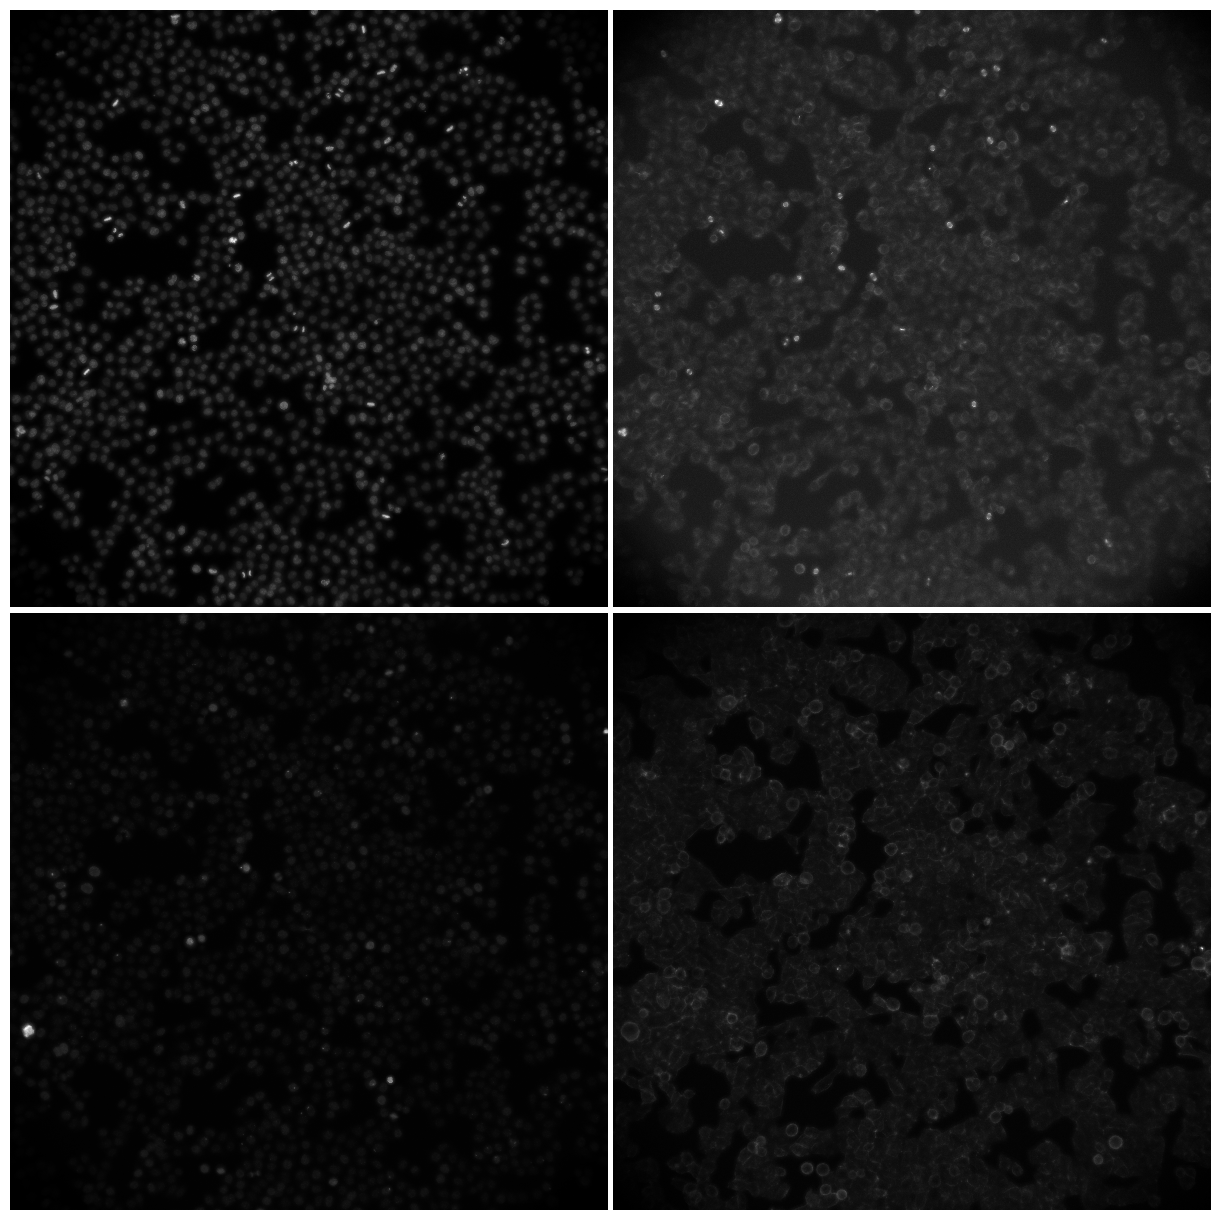

In [9]:
if PHENOTYPE_IMAGES_DIR_FP is not None:
    # Get test phenotype sample
    phenotype_sample = get_sample_fps(
        phenotype_samples,
        plate=1,
        well=phenotype_samples["well"][0],
        round_order=PHENOTYPE_ROUND_ORDER,
        channel_order=PHENOTYPE_CHANNEL_ORDER,
        verbose=True,
    )
    # Convert test phenotype sample to tiff
    phenotype_image, PHENOTYPE_TILES = nd2_to_tiff_well(
        phenotype_sample, position=0, channel_order_flip=PHENOTYPE_CHANNEL_ORDER_FLIP, return_tiles=True, verbose=True
    )

    # Create micropanel to display converted samples
    print("Converted phenotype test sample:")
    phenotype_microimages = [Microimage(image) for image in phenotype_image]
    phenotype_panel = create_micropanel(phenotype_microimages, add_channel_label=False)
    plt.show()

In [ ]:
if PHENOTYPE_IMAGES_DIR_FP is not None:
    # Get test phenotype sample
    phenotype_sample = get_sample_fps(
        phenotype_samples,
        plate=2,
        well=phenotype_samples["well"][0],
        round_order=PHENOTYPE_ROUND_ORDER,
        channel_order=PHENOTYPE_CHANNEL_ORDER,
        verbose=True,
    )
    # Convert test phenotype sample to tiff
    phenotype_image, PHENOTYPE_TILES = nd2_to_tiff_well(
        phenotype_sample, position=0, channel_order_flip=PHENOTYPE_CHANNEL_ORDER_FLIP, return_tiles=True, verbose=True
    )

    # Create micropanel to display converted samples
    print("Converted phenotype test sample:")
    phenotype_microimages = [Microimage(image) for image in phenotype_image]
    phenotype_panel = create_micropanel(phenotype_microimages, add_channel_label=False)
    plt.show()

In [ ]:
if PHENOTYPE_IMAGES_DIR_FP is not None:
    # Get test phenotype sample
    phenotype_sample = get_sample_fps(
        phenotype_samples,
        plate=3,
        well=phenotype_samples["well"][0],
        round_order=PHENOTYPE_ROUND_ORDER,
        channel_order=PHENOTYPE_CHANNEL_ORDER,
        verbose=True,
    )
    # Convert test phenotype sample to tiff
    phenotype_image, PHENOTYPE_TILES = nd2_to_tiff_well(
        phenotype_sample, position=0, channel_order_flip=PHENOTYPE_CHANNEL_ORDER_FLIP, return_tiles=True, verbose=True
    )

    # Create micropanel to display converted samples
    print("Converted phenotype test sample:")
    phenotype_microimages = [Microimage(image) for image in phenotype_image]
    phenotype_panel = create_micropanel(phenotype_microimages, add_channel_label=False)
    plt.show()

In [ ]:
if PHENOTYPE_IMAGES_DIR_FP is not None:
    # Get test phenotype sample
    phenotype_sample = get_sample_fps(
        phenotype_samples,
        plate=4,
        well=phenotype_samples["well"][0],
        round_order=PHENOTYPE_ROUND_ORDER,
        channel_order=PHENOTYPE_CHANNEL_ORDER,
        verbose=True,
    )
    # Convert test phenotype sample to tiff
    phenotype_image, PHENOTYPE_TILES = nd2_to_tiff_well(
        phenotype_sample, position=0, channel_order_flip=PHENOTYPE_CHANNEL_ORDER_FLIP, return_tiles=True, verbose=True
    )

    # Create micropanel to display converted samples
    print("Converted phenotype test sample:")
    phenotype_microimages = [Microimage(image) for image in phenotype_image]
    phenotype_panel = create_micropanel(phenotype_microimages, add_channel_label=False)
    plt.show()

In [ ]:
if PHENOTYPE_IMAGES_DIR_FP is not None:
    # Get test phenotype sample
    phenotype_sample = get_sample_fps(
        phenotype_samples,
        plate=5,
        well=phenotype_samples["well"][0],
        round_order=PHENOTYPE_ROUND_ORDER,
        channel_order=PHENOTYPE_CHANNEL_ORDER,
        verbose=True,
    )
    # Convert test phenotype sample to tiff
    phenotype_image, PHENOTYPE_TILES = nd2_to_tiff_well(
        phenotype_sample, position=0, channel_order_flip=PHENOTYPE_CHANNEL_ORDER_FLIP, return_tiles=True, verbose=True
    )

    # Create micropanel to display converted samples
    print("Converted phenotype test sample:")
    phenotype_microimages = [Microimage(image) for image in phenotype_image]
    phenotype_panel = create_micropanel(phenotype_microimages, add_channel_label=False)
    plt.show()

In [ ]:
if PHENOTYPE_IMAGES_DIR_FP is not None:
    # Get test phenotype sample
    phenotype_sample = get_sample_fps(
        phenotype_samples,
        plate=6,
        well=phenotype_samples["well"][0],
        round_order=PHENOTYPE_ROUND_ORDER,
        channel_order=PHENOTYPE_CHANNEL_ORDER,
        verbose=True,
    )
    # Convert test phenotype sample to tiff
    phenotype_image, PHENOTYPE_TILES = nd2_to_tiff_well(
        phenotype_sample, position=0, channel_order_flip=PHENOTYPE_CHANNEL_ORDER_FLIP, return_tiles=True, verbose=True
    )

    # Create micropanel to display converted samples
    print("Converted phenotype test sample:")
    phenotype_microimages = [Microimage(image) for image in phenotype_image]
    phenotype_panel = create_micropanel(phenotype_microimages, add_channel_label=False)
    plt.show()

In [ ]:
if PHENOTYPE_IMAGES_DIR_FP is not None:
    # Get test phenotype sample
    phenotype_sample = get_sample_fps(
        phenotype_samples,
        plate=7,
        well=phenotype_samples["well"][0],
        round_order=PHENOTYPE_ROUND_ORDER,
        channel_order=PHENOTYPE_CHANNEL_ORDER,
        verbose=True,
    )
    # Convert test phenotype sample to tiff
    phenotype_image, PHENOTYPE_TILES = nd2_to_tiff_well(
        phenotype_sample, position=0, channel_order_flip=PHENOTYPE_CHANNEL_ORDER_FLIP, return_tiles=True, verbose=True
    )

    # Create micropanel to display converted samples
    print("Converted phenotype test sample:")
    phenotype_microimages = [Microimage(image) for image in phenotype_image]
    phenotype_panel = create_micropanel(phenotype_microimages, add_channel_label=False)
    plt.show()

In [ ]:
if PHENOTYPE_IMAGES_DIR_FP is not None:
    # Get test phenotype sample
    phenotype_sample = get_sample_fps(
        phenotype_samples,
        plate=8,
        well=phenotype_samples["well"][0],
        round_order=PHENOTYPE_ROUND_ORDER,
        channel_order=PHENOTYPE_CHANNEL_ORDER,
        verbose=True,
    )
    # Convert test phenotype sample to tiff
    phenotype_image, PHENOTYPE_TILES = nd2_to_tiff_well(
        phenotype_sample, position=0, channel_order_flip=PHENOTYPE_CHANNEL_ORDER_FLIP, return_tiles=True, verbose=True
    )

    # Create micropanel to display converted samples
    print("Converted phenotype test sample:")
    phenotype_microimages = [Microimage(image) for image in phenotype_image]
    phenotype_panel = create_micropanel(phenotype_microimages, add_channel_label=False)
    plt.show()

## Create combo files 

In [10]:
# paths to combo dataframes
SBS_COMBO_DF_FP = "config/sbs_combo.tsv"
PHENOTYPE_COMBO_DF_FP = "config/phenotype_combo.tsv"

In [11]:
base_combos = sbs_samples[SBS_PATH_METADATA].drop_duplicates().astype(str)
# Create a list of all tiles
tiles = [str(i) for i in range(SBS_TILES)]
# Create product of base combos and tiles
sbs_wildcard_combos = pd.DataFrame([
    {**row.to_dict(), "tile": tile}
    for _, row in base_combos.iterrows()
    for tile in tiles
])
sbs_wildcard_combos.to_csv(SBS_COMBO_DF_FP, sep="\t", index=False)
print("SBS wildcard combos:")
display(sbs_wildcard_combos)

base_combos = phenotype_samples[PHENOTYPE_PATH_METADATA].drop_duplicates().astype(str)
# Create a list of all tiles
tiles = [str(i) for i in range(PHENOTYPE_TILES)]
# Create product of base combos and tiles
phenotype_wildcard_combos = pd.DataFrame([
    {**row.to_dict(), "tile": tile}
    for _, row in base_combos.iterrows()
    for tile in tiles
])
phenotype_wildcard_combos.to_csv(PHENOTYPE_COMBO_DF_FP, sep="\t", index=False)
print("Phenotype wildcard combos:")
display(phenotype_wildcard_combos)

SBS wildcard combos:


plate cycle well                                    channel tile
0          1     1   A1  DAPI-CY3_30p_545-A594_30p-CY5_30p-CY7_30p    0
1          1     1   A1  DAPI-CY3_30p_545-A594_30p-CY5_30p-CY7_30p    1
2          1     1   A1  DAPI-CY3_30p_545-A594_30p-CY5_30p-CY7_30p    2
3          1     1   A1  DAPI-CY3_30p_545-A594_30p-CY5_30p-CY7_30p    3
4          1     1   A1  DAPI-CY3_30p_545-A594_30p-CY5_30p-CY7_30p    4
...      ...   ...  ...                                        ...  ...
614380     8    11   B3                                    CY7_30p  328
614381     8    11   B3                                    CY7_30p  329
614382     8    11   B3                                    CY7_30p  330
614383     8    11   B3                                    CY7_30p  331
614384     8    11   B3                                    CY7_30p  332

[614385 rows x 5 columns]

Phenotype wildcard combos:


plate round well   channel  tile
0          1     1   A1  A594_1x1     0
1          1     1   A1  A594_1x1     1
2          1     1   A1  A594_1x1     2
3          1     1   A1  A594_1x1     3
4          1     1   A1  A594_1x1     4
...      ...   ...  ...       ...   ...
208798     8     2   B3   GFP_1x1  1276
208799     8     2   B3   GFP_1x1  1277
208800     8     2   B3   GFP_1x1  1278
208801     8     2   B3   GFP_1x1  1279
208802     8     2   B3   GFP_1x1  1280

[208803 rows x 5 columns]

## Create config file with params

In [12]:
# Create empty config variable
config = {}

# Add all section
config["all"] = {
    "root_fp": ROOT_FP,
}

# Add preprocess section
config["preprocess"] = {
    "sbs_samples_fp": SBS_SAMPLES_DF_FP,
    "sbs_combo_fp": SBS_COMBO_DF_FP,
    "phenotype_samples_fp": PHENOTYPE_SAMPLES_DF_FP,
    "phenotype_combo_fp": PHENOTYPE_COMBO_DF_FP,
    "sbs_channel_order": SBS_CHANNEL_ORDER,
    "phenotype_channel_order": PHENOTYPE_CHANNEL_ORDER,
    "phenotype_round_order": PHENOTYPE_ROUND_ORDER,
    "sbs_channel_order_flip": SBS_CHANNEL_ORDER_FLIP,
    "phenotype_channel_order_flip": PHENOTYPE_CHANNEL_ORDER_FLIP,
}

# Write the updated configuration back with markdown-style comments
with open(CONFIG_FILE_PATH, "w") as config_file:
    # Write the introductory markdown-style comments
    config_file.write(CONFIG_FILE_HEADER)

    # Dump the updated YAML structure, keeping markdown comments for sections
    yaml.dump(config, config_file, default_flow_style=False)